In [1]:
import sys
import os

pwd = os.getcwd()
python_path = pwd[: pwd.rfind("/")]
sys.path.append(python_path)

In [2]:
import torch
import lightning as pl
import jupyter_black
import segmentation_models_pytorch as smp
from data import FakeBacteriasDataModule
from models import BacteriasBinarySegmentation
from utils import show_images
from lightning.pytorch.loggers import TensorBoardLogger

jupyter_black.load()
torch.set_float32_matmul_precision("high")

In [3]:
class FPN(pl.LightningModule):
    def __init__(self, lr: float = 0.01):
        super().__init__()
        self.save_hyperparameters()
        self.model = smp.create_model(
            "FPN",
            "resnet34",
            in_channels=1,
            classes=1,
        )

    def configure_optimizers(self):
        lr: float = self.hparams.lr  # type: ignore
        return torch.optim.Adam(self.parameters(), lr=lr, betas=(0.5, 0.99))

    def loss(self, y_hat: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        loss_fn = smp.losses.JaccardLoss(smp.losses.BINARY_MODE, from_logits=True)
        return loss_fn(y_hat, y)

    def forward(self, x: torch.Tensor):
        y_hat = self.model(x)
        y_hat = y_hat.sigmoid()
        return y_hat

    def training_step(self, batch: tuple, batch_idx: int):
        x, y = batch

        y_hat = self.forward(x)
        loss = self.loss(y_hat, y)

        self.log_dict({"loss": loss}, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        pass

In [8]:
TRAIN_PARAMS = {"batch_size": 128, "num_workers": 1, "limit": 3000}
TEST_PARAMS = {"batch_size": 1, "num_workers": 1, "limit": 80}

LR = 0.001
EPOCHS = 20  # 20

fpn = FPN(lr=LR)
logger = (TensorBoardLogger(save_dir="../../logs/fpn"),)
datamodule = FakeBacteriasDataModule(train_params=TRAIN_PARAMS, test_params=TEST_PARAMS)

trainer = pl.Trainer(
    max_epochs=EPOCHS, accelerator="gpu", devices=1, logger=logger, log_every_n_steps=10
)
_ = trainer.fit(model=fpn, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | FPN  | 23.1 M
-------------------------------
23.1 M    Trainable params
0         Non-trainable params
23.1 M    Total params
92.596    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 

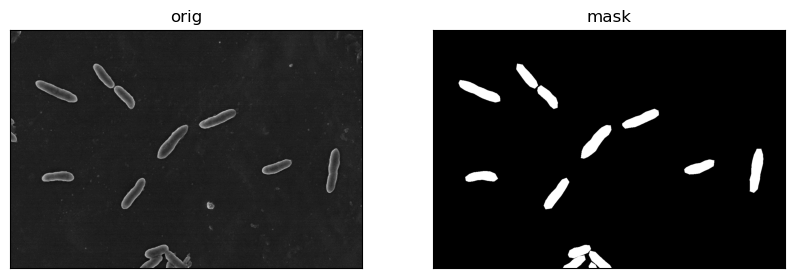

In [9]:
datamodule.setup("test")
test_loader = datamodule.test_dataloader()
for _, batch in enumerate(test_loader):
    x, y = batch
    idx = torch.randint(0, len(x), (1,)).item()
    get_np_img = lambda tens: tens.detach()[idx].numpy().squeeze()
    show_images([(get_np_img(x), "orig"), (get_np_img(y), "mask")])
    break

2
0


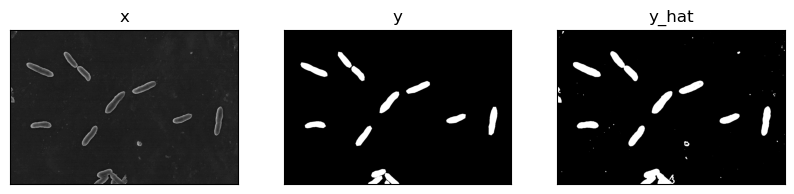

In [10]:
batch = next(iter(datamodule.test_dataloader()))
print(len(batch))

with torch.no_grad():
    fpn.eval()
    x, y = batch
    y_hat = fpn(x)
    idx = torch.randint(0, len(x), (1,)).item()
    print(idx)
show_images(
    [
        (x.detach()[idx].numpy().squeeze(), "x"),
        (y.detach()[idx].numpy().squeeze(), "y"),
        (y_hat.detach()[idx].numpy().squeeze(), "y_hat"),
    ],
    grid=(1, 3),
)

2
0


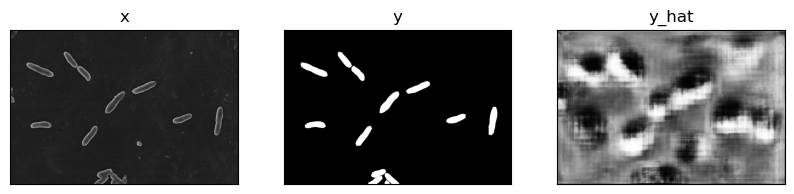

In [6]:
batch = next(iter(datamodule.test_dataloader()))
print(len(batch))

with torch.no_grad():
    fpn.eval()
    x, y = batch
    y_hat = fpn(x)
    idx = torch.randint(0, len(x), (1,)).item()
    print(idx)
show_images(
    [
        (x.detach()[idx].numpy().squeeze(), "x"),
        (y.detach()[idx].numpy().squeeze(), "y"),
        (y_hat.detach()[idx].numpy().squeeze(), "y_hat"),
    ],
    grid=(1, 3),
)